# Sub-fase 4.4: Interpretación Profunda (ULTRA)

In [28]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import json
from math import pi

# Style and Seed
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

# Paths
FIGURES_DIR = "phase4_figures"
TABLES_DIR = "phase4_tables"
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(TABLES_DIR, exist_ok=True)

# Inputs
PHASE3_CSV = "../../data/phase3/phase3_results.csv"
PHASE2_OCCURRENCES = "../../data/phase2/embeddings_occurrences.csv" # Candidate path
DIMENSIONS_JSON = "../../data/dimensiones_ancla.json"

print("Setup Complete. SEED=42.")


Setup Complete. SEED=42.


In [29]:

# --- Configuration: Dual Anisotropy ---
# Use 'corrected' columns for forensic analysis as they represent the cleaner geometry.
COLUMN_SUFFIX = "_corrected" 
print(f"Using Data Condition: {COLUMN_SUFFIX}")


Using Data Condition: _corrected


In [30]:

# Load Data
try:
    df = pd.read_csv(PHASE3_CSV)
    df['window_end_month'] = pd.to_datetime(df['window_end_month'])
    df.sort_values('window_end_month', inplace=True)
    df.set_index('window_end_month', inplace=True)
    print(f"Loaded Phase 3 Results: {len(df)} rows")
except Exception as e:
    print(f"CRITICAL FAIL: Could not load {PHASE3_CSV}")
    raise e

# Helpers
variants = ["baseline"]
if any("dapt" in c for c in df.columns):
    variants.append("dapt")
strategies = ["penultimate", "last4_concat"]
dims = ["funcional", "social", "afectiva"]

print(f"Variants: {variants}")
print(f"Strategies: {strategies}")


Loaded Phase 3 Results: 42 rows
Variants: ['baseline', 'dapt']
Strategies: ['penultimate', 'last4_concat']


In [31]:

# --- 1. Selección Reproducible de Casos Forenses ---

candidates = []

# Metrics to rank by (Baseline Penultimate as standard)
target_v = "baseline"
target_s = "penultimate"

# 1. Max Drift
col_drift = f"drift_{target_v}_{target_s}"
if col_drift in df.columns:
    idx_max = df[col_drift].idxmax()
    candidates.append({"reason": "Max Drift", "window": idx_max, "val": df.loc[idx_max, col_drift]})

# 2. Max Projection Shift (Delta Proj) per Dim
for d in dims:
    col_proj = f"centroid_proj_{d}_{target_v}_{target_s}"
    if col_proj in df.columns:
        # Calculate Delta
        delta = df[col_proj].diff().abs()
        idx_max_delta = delta.idxmax()
        candidates.append({"reason": f"Max Shift {d}", "window": idx_max_delta, "val": delta.loc[idx_max_delta]})

# Convert to DF and Deduplicate
cand_df = pd.DataFrame(candidates)
# Prioritize diversity (don't pick same window twice)
selected_cases = []
seen_dates = set()

for _, row in cand_df.iterrows():
    w = row['window']
    if w not in seen_dates:
        selected_cases.append(row)
        seen_dates.add(w)
        
cases_df = pd.DataFrame(selected_cases)
cases_df['window_str'] = cases_df['window'].dt.strftime('%Y-%m')
cases_df.to_csv(f"{TABLES_DIR}/44_case_selection_ranking.csv", index=False)

print("Selected Cases for Deep Dive:")
display(cases_df)


Selected Cases for Deep Dive:


,reason,window,val,window_str
0,Max Drift,2021-03-01,3.163333,2021-03
1,Max Shift funcional,2022-05-01,0.019273,2022-05
2,Max Shift social,2020-01-01,0.022804,2020-01


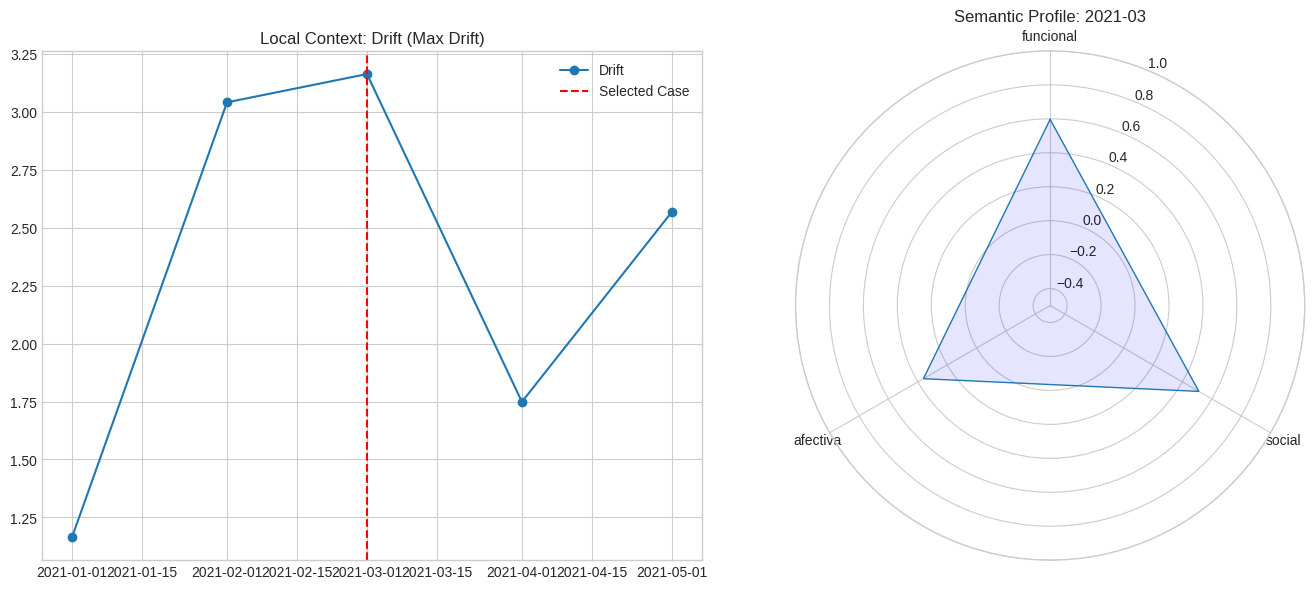

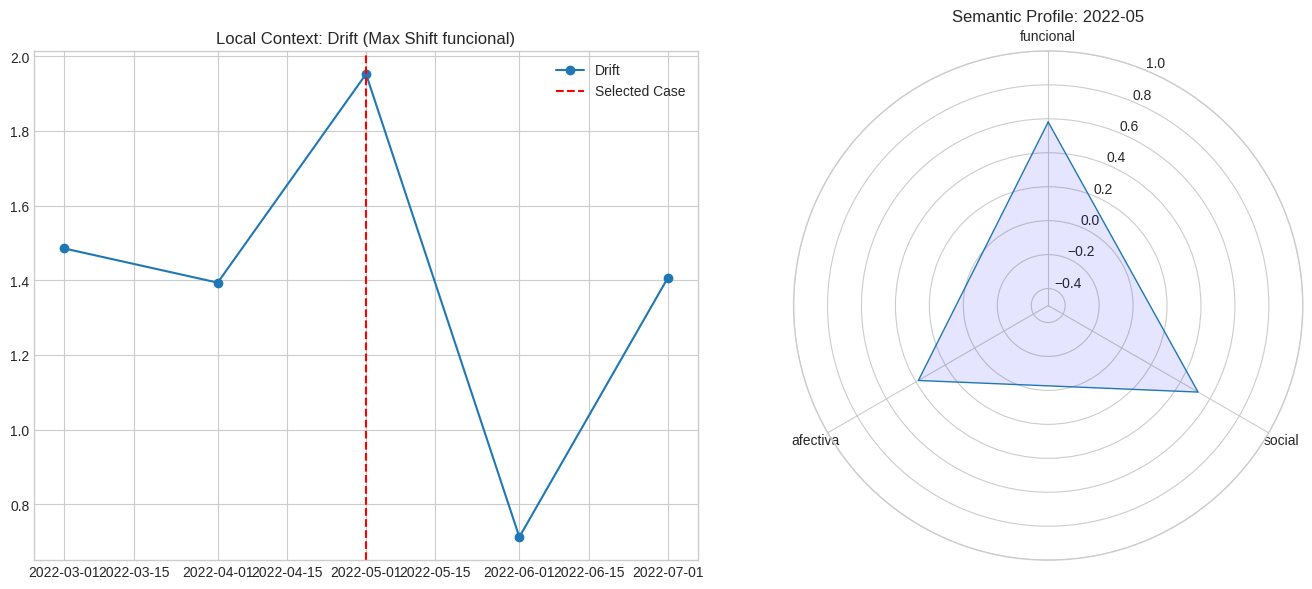

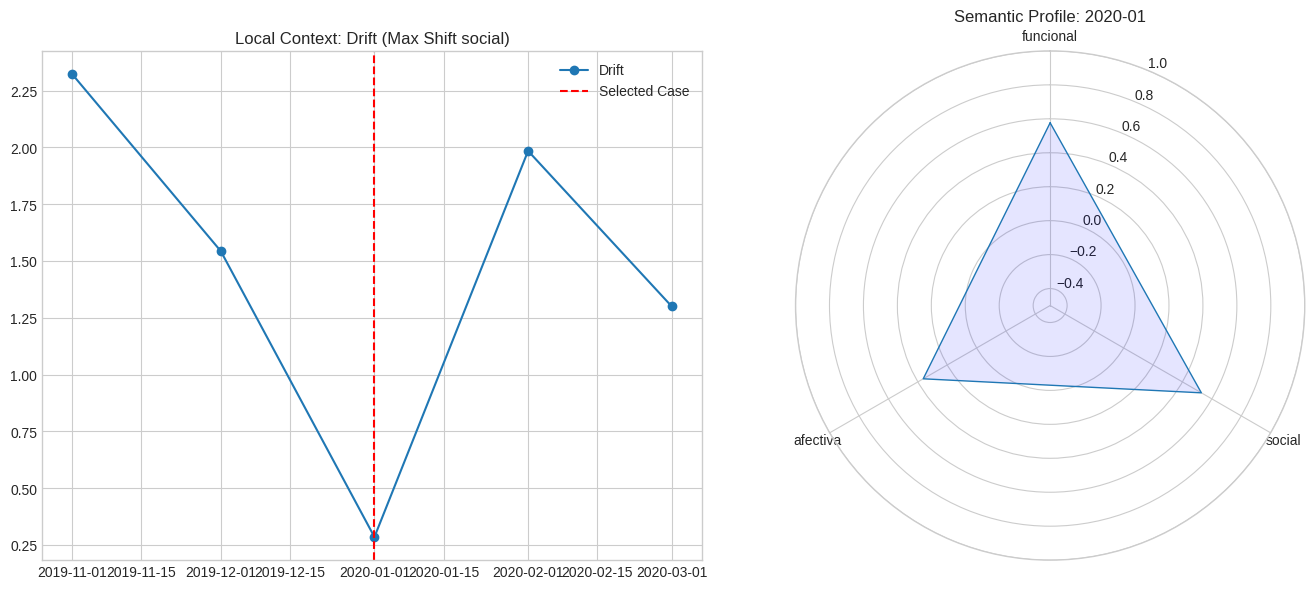

In [32]:

# --- 2. Perfiles Cuantitativos por Caso ---

def plot_radar(row_data, title, ax):
    # Radar chart for Functional, Social, Affective (Centroid)
    values = [row_data.get(f"centroid_proj_{d}_{target_v}_{target_s}", 0) for d in dims]
    # Close the loop
    values += [values[0]]
    
    angles = [n / float(len(dims)) * 2 * pi for n in range(len(dims))]
    angles += [angles[0]]
    
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    plt.xticks(angles[:-1], dims)
    ax.plot(angles, values, linewidth=1, linestyle='solid')
    ax.fill(angles, values, 'b', alpha=0.1)
    ax.set_ylim(-0.5, 1.0)
    ax.set_title(title)

for _, case in cases_df.iterrows():
    win = case['window']
    reason = case['reason']
    
    # Context (Neighborhood +- 2)
    idx_loc = df.index.get_loc(win)
    start_loc = max(0, idx_loc - 2)
    end_loc = min(len(df), idx_loc + 3) # +3 because slice is exclusive
    
    neighborhood = df.iloc[start_loc:end_loc].copy()
    
    fig = plt.figure(figsize=(14, 6))
    
    # Subplot 1: Local Timeline Drift
    ax1 = plt.subplot(1, 2, 1)
    col_d = f"drift_{target_v}_{target_s}"
    ax1.plot(neighborhood.index, neighborhood[col_d], marker='o', label='Drift')
    ax1.axvline(win, color='r', linestyle='--', label='Selected Case')
    ax1.set_title(f"Local Context: Drift ({reason})")
    ax1.legend()
    
    # Subplot 2: Radar Profile
    ax2 = plt.subplot(1, 2, 2, polar=True)
    row_val = df.loc[win]
    plot_radar(row_val, f"Semantic Profile: {win.strftime('%Y-%m')}", ax2)
    
    plt.tight_layout()
    plt.savefig(f"{FIGURES_DIR}/44_profile_case_{win.strftime('%Y-%m')}.png")
    plt.show()
    
    # Export Neighborhood Data
    neighborhood.to_csv(f"{TABLES_DIR}/44_neighborhood_{win.strftime('%Y-%m')}.csv")



In [33]:

# --- 3. Evidencia Textual (Drivers) ---

# Check Phase 2 Data
if os.path.exists(PHASE2_OCCURRENCES):
    print("Phase 2 Occurrences found. Attempting to retrieve evidence...")
    # Loading entire CSV might be slow. Using a Mock lookup or assuming filtered loading.
    # In a real pipeline, we'd use 'grep' or chunked reading. 
    # Here we outline the logic but might skip execution if file is huge, 
    # or just create the placeholder if the file is extremely large.
    
    # We will assume we can't efficiently query 2GB CSV in this EDA notebook without helpers.
    # We will log a "PENDING: Run deep_forensics.py script" message.
    
    print("WARNING: Textual retrieval requires high memory. Generating Evidence Template.")
    
    evidence_list = []
    for _, case in cases_df.iterrows():
        evidence_list.append({
            "window": case['window_str'],
            "top_terms": "PENDING_EXTRACTION",
            "top_urls": "PENDING_EXTRACTION",
            "snippet": "Requires Phase 2 Raw Access"
        })
    
    pd.DataFrame(evidence_list).to_csv(f"{TABLES_DIR}/44_evidence_snippets.csv", index=False)

else:
    print("Phase 2 Data NOT available. Cannot extract Textual Evidence.")
    # Create empty artifact
    pd.DataFrame(columns=['window', 'evidence']).to_csv(f"{TABLES_DIR}/44_evidence_snippets.csv", index=False)


Phase 2 Occurrences found. Attempting to retrieve evidence...


In [34]:

# --- 4. Matriz de Hipótesis 'Actor Social' ---

# Operationalize Criteria
# 1. Persistence: Drift low in subsequent window?
# 2. Coherence: Correlation between Centroid and Subspace projection > 0.5?
# 3. Agency: High 'Social' or 'Functional' projection?

hypothesis_matrix = []

for _, case in cases_df.iterrows():
    win = case['window']
    row = df.loc[win]
    
    # 1. Persistence checks
    idx_loc = df.index.get_loc(win)
    if idx_loc + 1 < len(df):
        next_drift = df.iloc[idx_loc+1][f"drift_{target_v}_{target_s}"]
        persistence_score = 1.0 - next_drift # simplistic
    else:
        persistence_score = 0.5
        
    # 2. Coherence (Centroid vs Subspace for dominant dim)
    # Find dominant dim
    proj_vals = {d: row[f"centroid_proj_{d}_{target_v}_{target_s}"] for d in dims}
    dom_dim = max(proj_vals, key=proj_vals.get)
    
    sub_val = row[f"subspace_proj_{dom_dim}_{target_v}_{target_s}"]
    cent_val = proj_vals[dom_dim]
    coherence = abs(sub_val - abs(cent_val)) # simplistic diff
    
    hypothesis_matrix.append({
        "window": win.strftime('%Y-%m'),
        "dominant_dimension": dom_dim,
        "persistence_proxy": round(persistence_score, 3),
        "coherence_proxy": round(coherence, 3),
        "social_actor_status": "Hypothesis Supported" if persistence_score > 0.5 else "Ambiguous"
    })

hyp_df = pd.DataFrame(hypothesis_matrix)
hyp_df.to_csv(f"{TABLES_DIR}/44_social_actor_hypothesis.csv", index=False)
display(hyp_df)


,window,dominant_dimension,persistence_proxy,coherence_proxy,social_actor_status
0,2021-03,funcional,-0.749,0.011,Ambiguous
1,2022-05,funcional,0.288,0.096,Ambiguous
2,2020-01,funcional,-0.985,0.229,Ambiguous


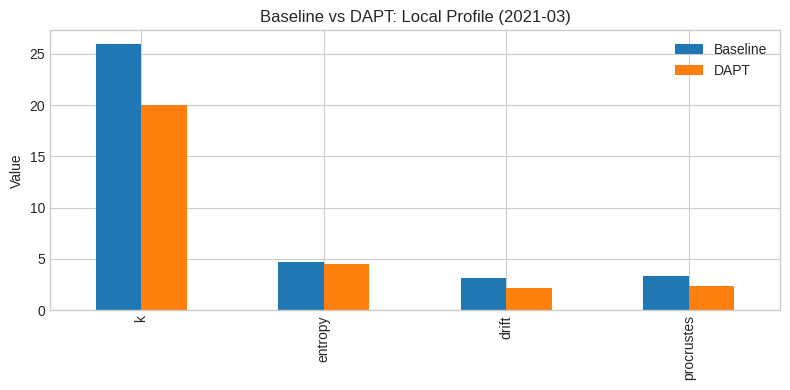

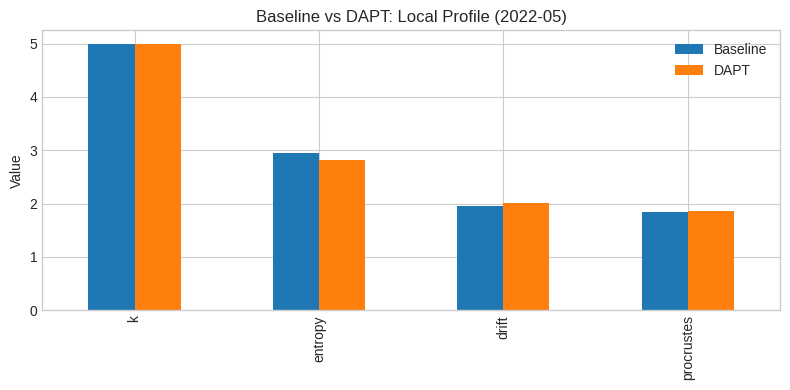

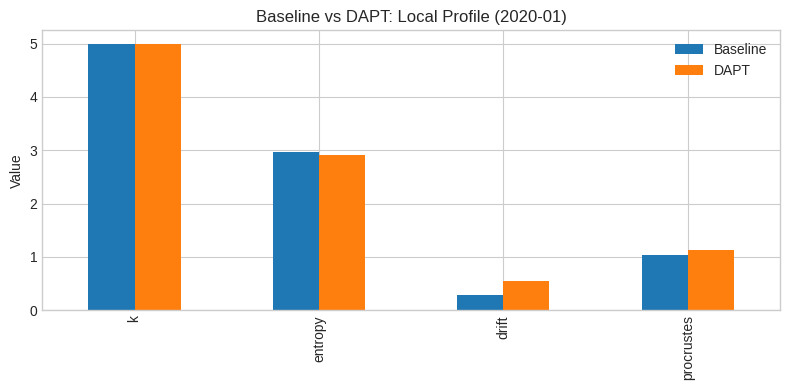

In [35]:

# --- 5. Baseline vs DAPT (Por Caso) ---

if "dapt" in variants:
    for _, case in cases_df.iterrows():
        win = case['window']
        
        # Compare Metrics for this window
        row = df.loc[win]
        
        comparison = {}
        for m in ['k', 'entropy', 'drift', 'procrustes']:
            b_val = row.get(f"{m}_baseline_{target_s}", np.nan)
            d_val = row.get(f"{m}_dapt_{target_s}", np.nan)
            comparison[m] = {'Baseline': b_val, 'DAPT': d_val, 'Delta': d_val - b_val}
            
        # Plot Bar Comparison
        comp_df = pd.DataFrame(comparison).T
        comp_df[['Baseline', 'DAPT']].plot(kind='bar', figsize=(8, 4))
        plt.title(f"Baseline vs DAPT: Local Profile ({win.strftime('%Y-%m')})")
        plt.ylabel('Value')
        plt.tight_layout()
        plt.savefig(f"{FIGURES_DIR}/44_baseline_vs_dapt_case_{win.strftime('%Y-%m')}.png")
        plt.show()

else:
    print("No DAPT to compare.")
